In [1]:
import operator
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Consider value '0' as NaN.
xm_settle = pd.read_csv("data/8_m_settle.csv", usecols=range(1,10), dtype=np.float32,
                        parse_dates=[0], header=0, index_col=0, na_values=0)
xm_symbols = pd.read_csv("data/8_m_symbols.csv", usecols=range(1,10), parse_dates=[0],
                         header=0, index_col=0, na_values=0)
expiration_months = pd.read_csv("data/expiration.months.csv", header=0, usecols=range(1,13), dtype=np.float32)
vix_index = pd.read_csv("data/vix.csv", parse_dates=[0], header=0, index_col=0, na_values="null",
                        dtype=np.float32)

## Plot all the term structures in some large range
Helpful to get a general feeling.

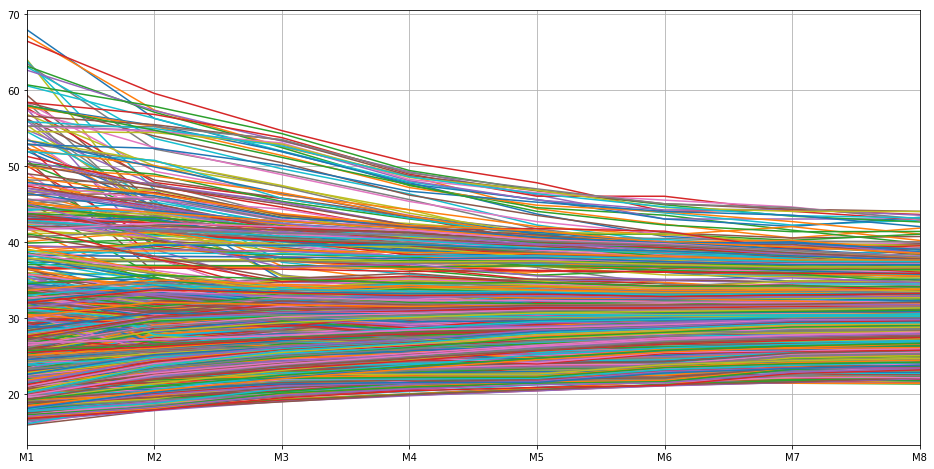

In [3]:
# Plot part of the data.
lines = xm_settle.iloc[1000:2000].T
lines.fillna(method='pad').plot(legend=False, figsize=(16,8))
plt.grid()
plt.show()

## And this is a single term structure
One of the nice and clean ones.

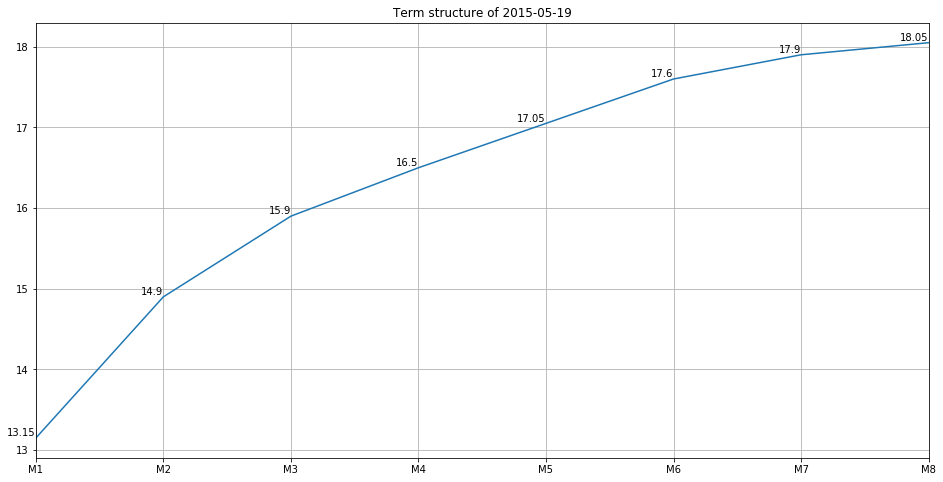

In [4]:
data_line = xm_settle.iloc[-500]
data_line.T.plot(legend=False, figsize=(16,8))
for i in range(len(data_line)):
    plt.text(i, data_line[i], data_line[i], horizontalalignment="right", verticalalignment="bottom")
plt.title("Term structure of {}".format(data_line.name.date()))
plt.grid()
plt.show()

## Here I plot the contangos for a large range
Notice how the fluctuation of the M2-M1 contango is the largest while it steadily decreases for later expiration months.

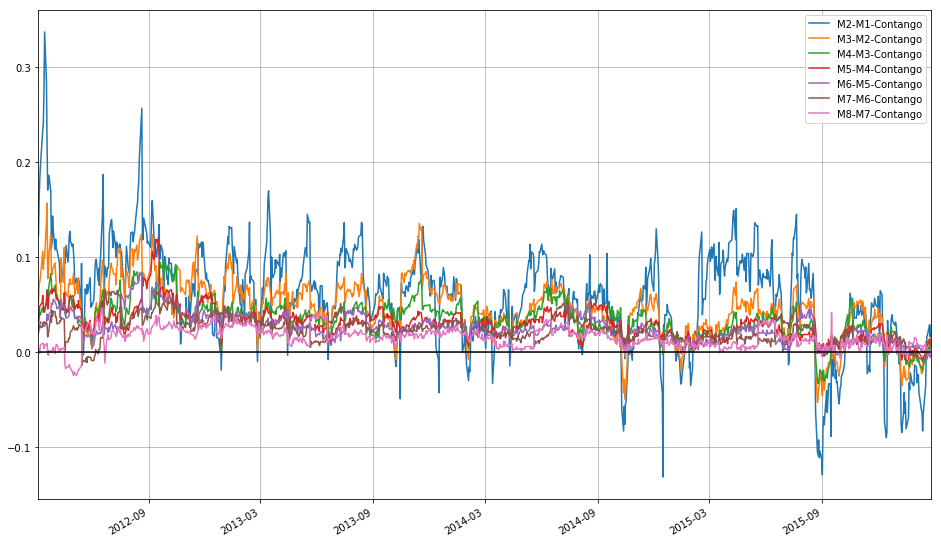

In [5]:
mxs = [xm_settle.iloc[2000:3000, i] for i in range(8)]
contangos = [(mxs[i + 1] - mxs[i]) / mxs[i] for i in range(8 - 1)]
contango_labels = ["M{}-M{}-Contango".format(i+1, i) for i in range(1,8)]
plt.figure(figsize=(16,10))
for i in range(len(contangos)):
    contangos[i].plot(label=contango_labels[i], legend=True)
plt.axhline(0, color="black")
plt.xlabel("")
plt.grid()
plt.show()

In [6]:
vix = vix_index["Adj Close"]   # Only this one is needed for the index.
trainingdata = pd.merge(pd.DataFrame(vix), xm_settle, left_index=True, right_index=True)

## Experimenting with data normalization

The make sure the training error isn't exploding it's best to normalize the data so its in (-1,1)-range. Doing this as simple as possible is preferred. Too much data wrangling beforehand might introduce some unwanted prior. Wenn normalizing the data all NaN values (including 0) aren't considered because they stand for not available data and influence the result too much.

In [7]:
mean = trainingdata.mean()
ptp = trainingdata.max() - trainingdata.min()
normalized = (trainingdata - mean) / ptp

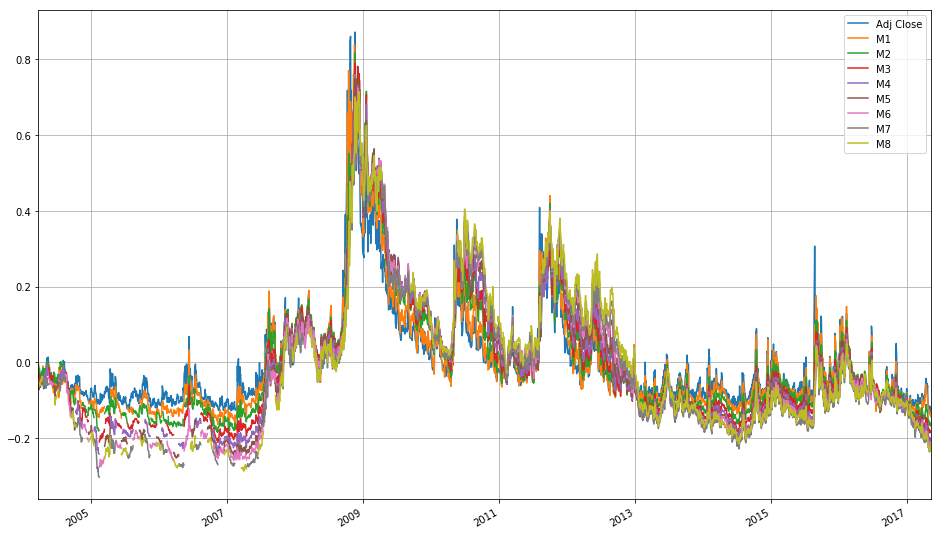

In [8]:
normalized.plot(figsize=(16,10))
plt.grid()
plt.show()

## Mapping Data to anual structure

At the moment you have a x-axis [M1,...,M8] but I want it [Jan,Feb,...,Dec]. All the points without given values are NaN. Something like expiration_months but with dates.

In [9]:
# Create a new data frame (not very efficient)
xm_year = pd.DataFrame(index=xm_settle.index, columns=expiration_months.columns, dtype=np.float32)
def symbol_to_month(symbol):
    mapping_dict = {"F":"January", "G":"February", "H":"March", "J":"April", "K":"May", "M":"June",
                    "N":"July", "Q":"August", "U":"September", "V":"October", "X":"November", "Z":"December"}
    return mapping_dict[symbol[0]]
for date, data in xm_year.iterrows():
    symbol = xm_symbols.loc[date].dropna().map(symbol_to_month)
    settle = xm_settle[symbol.index].loc[date]
    data[symbol] = settle

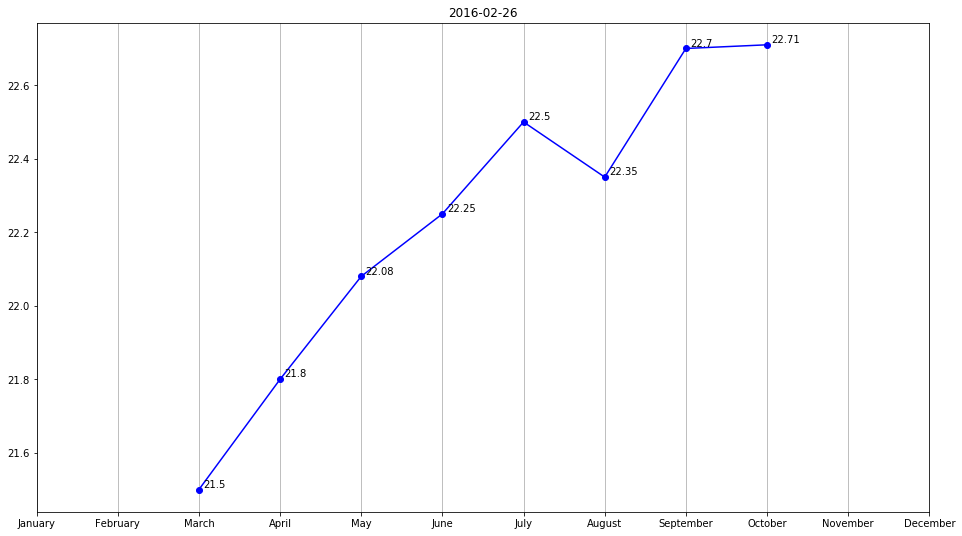

In [109]:
def plot_xm_year(index, scale=None, save=False):
    global xm_year
    month_to_x = {month:idx for idx, month in enumerate(xm_year.columns)}
    data = xm_year.iloc[index].dropna()
    x = data.rename(month_to_x).index.values
    y = data.values
    global xm_symbols
    months = xm_symbols.iloc[index].dropna().map(symbol_to_month).map(month_to_x)
    months_increasing = all(months[i] < months[i+1] for i in range(len(months) - 1))
    plt.figure(figsize=(16,9))
    if months_increasing:
        plt.plot(x, y, "-ob")
    else:
        splitindex = len(months) - months.values.argmin()
        plt.plot(x[:splitindex], y[:splitindex], "-ob")
        plt.plot(x[splitindex:], y[splitindex:], "-ob")
    plt.xticks(np.arange(12), xm_year.columns)
    if scale:
        y_min = xm_year.min().min()
        y_max = xm_year.max().max()
        plt.ylim(y_min, y_max)
    plt.xlim(0, 11)
    ydiff = plt.ylim()[1] - plt.ylim()[0]
    xdiff = plt.xlim()[1] - plt.xlim()[0]
    for idx, idy in zip(x, y):
        plt.text(idx + xdiff/200, idy + ydiff/200, idy)
    plt.grid(axis="x")
    plt.title(xm_year.iloc[index].name.date())
    if save:
        plt.savefig("img_annual_structure/{:04d}.png".format(index))
        plt.close()
    else:
        plt.show()
plot_xm_year(3000)

In [91]:
# Create a new data frame for spread prices
long_prices = pd.DataFrame(index=xm_year.index, columns=xm_year.columns, dtype=np.float32)
for date, data in xm_year.iterrows():
    data = np.concatenate((data[0:1], data, data[-1:]))
    # Calculate long prices (buy 2-1-1)
    prices = [2*data[i] - data[i-1] - data[i+1] for i in range(1,13)]
    long_prices.loc[date] = prices

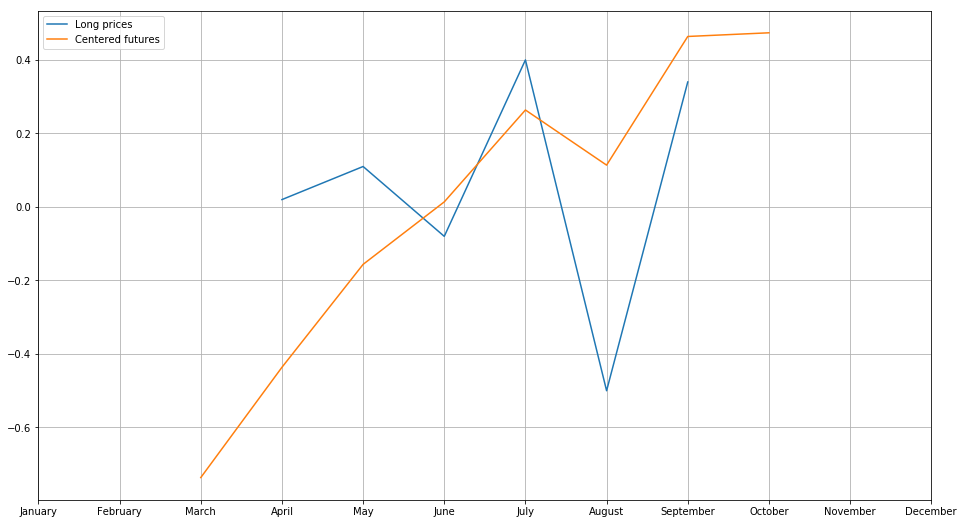

In [130]:
index = 3000
long_prices.iloc[3000].plot(figsize=(16,9))
(xm_year.iloc[3000] - xm_year.iloc[3000].mean()).plot()
plt.grid()
plt.xticks(np.arange(12), long_prices.columns)
plt.legend(("Long prices", "Centered futures"), loc="upper left")
plt.show()

In [131]:
# There are times when no spread prices can be calculated.
long_prices.dropna(how="all").shape

(2887, 12)